# Training notebook

This notebook contains the training code for the Starbucks Capstone Challenge.

It has got the following structure:
* Checking the correlation of the features in the training data
* Based on this seleceting the sufficient features
* Shuffleing the data
* splitting the data into train, validation and test sets
* creating data loaders
* defining the models
* finding sufficient hyperparameters
* training the models
* evaluating the trained models
* compare the results
---

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from importlib import reload
from sklearn.model_selection import train_test_split

from source import training_helpers
from source import model
from source.model import Linear_NN
from source import solver

In [57]:
# setting up torch device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('cuda is avalilabe' if torch.cuda.is_available() else 'cuda is NOT avaliable')

cuda is avalilabe


In [58]:
reload(training_helpers)
reload(model)
reload(solver)

<module 'source.solver' from '/home/ferenc/Documents/Udacity/Machine_Learning_Engineer/Starbucks_Capstone_Project/source/solver.py'>

### loading the dataset and checking feature correlation

In [61]:
# loading the data:
data_dir = 'data'
data_file = 'training_data_standardized.csv'
training_data_df = training_helpers.load_training_data(data_dir=data_dir, data_file=data_file)
training_data_df.head()

Read training data from data/training_data_standardized.csv


,F,M,O,U,age,income,membership_length,av_money_spent,num_received,viewed/received,...,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,label
0,1.0,0.0,0.0,0.0,1.193501,1.654475,0.132255,-0.763102,-1.206595,-1.292364,...,0,0,1,0,0,0,0,0,0,3
1,0.0,0.0,0.0,1.0,0.000000,0.000000,-0.011285,-0.763102,-1.206595,-1.292364,...,0,0,0,1,0,0,0,0,0,3
2,0.0,1.0,0.0,0.0,0.792728,0.253302,-1.245015,-0.763102,-1.206595,-1.292364,...,0,0,0,0,0,0,0,0,1,3
3,0.0,0.0,0.0,1.0,0.000000,0.000000,-0.253576,-0.763102,-1.206595,-1.292364,...,1,0,0,0,0,0,0,0,0,3
4,0.0,1.0,0.0,0.0,0.620969,-0.540695,-0.865163,-0.763102,-1.206595,-1.292364,...,0,0,0,0,0,0,0,1,0,3


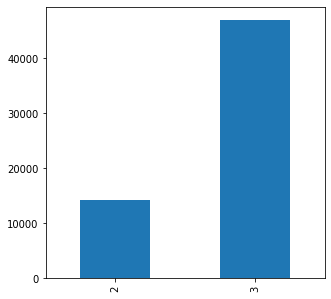

In [63]:
# chceking the number of labels in the dataset:
label_counts_df = training_data_df.label.value_counts().sort_index()
fig = plt.figure(figsize=(5,5))
label_counts_df.plot.bar()

In [5]:
# checking the correlation matrix:
training_data_df.corr()

,F,M,O,U,age,income,membership_length,av_money_spent,num_received,viewed/received,...,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,label
F,1.000000,-0.742123,-0.080854,-0.288567,0.144789,0.222408,0.011123,0.198040,-0.004785,0.001956,...,0.002295,0.001120,-0.000737,0.006749,-0.004738,-0.004614,0.004370,-0.002159,-0.002574,-0.004166
M,-0.742123,1.000000,-0.110272,-0.393560,-0.137893,-0.210736,-0.003784,-0.035368,0.002142,-0.027004,...,-0.001056,0.000916,-0.000871,-0.002849,0.003803,0.005320,-0.004631,-0.000889,0.002432,0.002820
O,-0.080854,-0.110272,1.000000,-0.042878,-0.003326,-0.013558,-0.009273,0.018863,-0.004134,0.012073,...,-0.008012,0.000654,0.001314,0.002979,0.002733,-0.000603,0.002963,-0.001584,-0.002334,-0.002745
U,-0.288567,-0.393560,-0.042878,1.000000,0.000406,0.001730,-0.007125,-0.232751,0.004901,0.033187,...,0.000882,-0.003135,0.001902,-0.006255,0.000195,-0.001151,-0.000275,0.004855,0.000786,0.002587
age,0.144789,-0.137893,-0.003326,0.000406,1.000000,0.300572,0.020466,0.080883,-0.001565,0.014495,...,-0.002082,0.004210,-0.002300,0.002606,-0.000767,-0.000065,0.005979,0.000075,-0.005924,-0.007731
income,0.222408,-0.210736,-0.013558,0.001730,0.300572,1.000000,0.047885,0.244121,-0.006509,0.028156,...,0.003162,0.000764,-0.003768,-0.001267,-0.000318,-0.005584,0.003583,0.002338,-0.002103,-0.003298
membership_length,0.011123,-0.003784,-0.009273,-0.007125,0.020466,0.047885,1.000000,0.176122,0.000882,0.006887,...,0.005271,0.000403,0.004939,0.000589,-0.010036,0.001721,0.001926,-0.005336,-0.000274,-0.001767
av_money_spent,0.198040,-0.035368,0.018863,-0.232751,0.080883,0.244121,0.176122,1.000000,0.313841,0.396038,...,0.013244,0.018239,0.002616,-0.019673,-0.011763,-0.036415,0.021134,0.016454,-0.005191,-0.029876
num_received,-0.004785,0.002142,-0.004134,0.004901,-0.001565,-0.006509,0.000882,0.313841,1.000000,0.516739,...,0.073504,0.073351,-0.030938,-0.108061,-0.024229,-0.105950,0.067890,0.069505,-0.026006,-0.107171
viewed/received,0.001956,-0.027004,0.012073,0.033187,0.014495,0.028156,0.006887,0.396038,0.516739,1.000000,...,0.021825,0.022699,-0.009611,-0.035243,-0.002591,-0.042932,0.019774,0.027679,-0.005509,-0.032227


The features does not seem to be correlated to eachother, so we keep all of them

### Extracting the training features and the labels

In [6]:
X = training_data_df.values[:, :-1].astype(np.float32)
y = training_data_df.values[:, -1].astype(np.float32)

# deleting the original dataframe:
training_data_df = None

### Shuffleing and splitting the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print('training size: {}'.format(X_train.shape))
print('validation size: {}'.format(X_val.shape))
print('test size: {}'.format(X_test.shape))

training size: (49671, 26)
validation size: (5520, 26)
test size: (6133, 26)


In [8]:
type(X_train[0, 0])

numpy.float32

### Creating the data loader

In [9]:
# converting the data into torch.tensor:
X_train = torch.as_tensor(X_train, dtype=torch.float).to(device)
X_val = torch.as_tensor(X_val, dtype=torch.float).to(device)
X_test = torch.as_tensor(X_test, dtype=torch.float).to(device)

y_train = torch.as_tensor(y_train, dtype=torch.long).to(device)
y_val = torch.as_tensor(y_val, dtype=torch.long).to(device)
y_test = torch.as_tensor(y_test, dtype=torch.long).to(device)

In [46]:
# creating datasets for the dataloaders:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 10
# creating the data loaders:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Defining the Linear Feed forward neural network:

The network is defined in `source/model.py`

In [59]:
# network parameters:
input_dim = X_train.shape[1]
output_dim = 4
hidden_dims = [64]
dropout = 0.2

# instantiating the model:
model_NN = Linear_NN(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, dropout=dropout)
model_NN.to(device)

NN_solver = solver.NN_Solver(optim_args={"lr": 1e-4, "weight_decay": 0},
                loss_func=torch.nn.CrossEntropyLoss())
best_state_dict = NN_solver.train(model_NN, train_loader, val_loader, log_nth=500, num_epochs=30)

START TRAINING
Epoch 0/29
learning rate : 0.0001
----------
pred_labels: tensor([1, 3, 0, 0, 3, 3, 3, 0, 0, 0], device='cuda:0',
       grad_fn=<NotImplemented>)
labels: tensor([2, 3, 3, 3, 2, 3, 3, 3, 3, 3], device='cuda:0')
Iteration 0/4968 train accuracy : 0.3
pred_labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0',
       grad_fn=<NotImplemented>)
labels: tensor([2, 3, 2, 2, 2, 3, 3, 3, 3, 3], device='cuda:0')
Iteration 500/4968 train accuracy : 0.6
pred_labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0',
       grad_fn=<NotImplemented>)
labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Iteration 1000/4968 train accuracy : 1.0
pred_labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0',
       grad_fn=<NotImplemented>)
labels: tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Iteration 1500/4968 train accuracy : 0.9
pred_labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0',
       grad_fn=<NotImplemented>)
labels: tensor

pred_labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 2, 3], device='cuda:0',
       grad_fn=<NotImplemented>)
labels: tensor([3, 3, 3, 3, 2, 3, 3, 3, 2, 3], device='cuda:0')
Iteration 19000/4968 train accuracy : 0.9
pred_labels: tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0',
       grad_fn=<NotImplemented>)
labels: tensor([2, 3, 3, 3, 2, 3, 3, 3, 3, 3], device='cuda:0')
Iteration 19500/4968 train accuracy : 0.9
EPOCH 3/29 TRAIN loss/acc : 0.744/100.00%
EPOCH 3/29 VAL loss/acc : 0.744/100.00%
----------
Epoch 4/29
learning rate : 0.0001
----------
pred_labels: tensor([3, 3, 3, 3, 3, 3, 3, 2, 2, 3], device='cuda:0',
       grad_fn=<NotImplemented>)
labels: tensor([3, 3, 3, 3, 3, 3, 3, 2, 2, 3], device='cuda:0')
Iteration 20000/4968 train accuracy : 1.0
pred_labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0',
       grad_fn=<NotImplemented>)
labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Iteration 20500/4968 train accuracy : 1.0
pred_labels: tensor([2, 3, 3, 

KeyboardInterrupt: 

### Training the network
The solver class is defined in `source/solver.py`

First we are checking the implementation by overfitting ot a single data instance:

In [31]:
# converting the data into torch.tensor:
X_train_single = torch.as_tensor(X_train[0, :].reshape(1, -1), dtype=torch.float).to(device)
X_val_single = torch.as_tensor(X_val[0, :].reshape(1, -1), dtype=torch.float).to(device)

y_train_single = torch.as_tensor(y_train[0].reshape(1), dtype=torch.long).to(device)
y_val_single = torch.as_tensor(y_val[0].reshape(1), dtype=torch.long).to(device)

In [32]:
# network parameters:
input_dim = X_train.shape[1]
output_dim = 4
hidden_dims = [64]
dropout = 0.2

In [33]:
# testing the model by overfitting to a single data instance:
train_dataset_single = TensorDataset(X_train_single, y_train_single)
val_dataset_single = TensorDataset(X_val_single, y_val_single)
train_loader_single = torch.utils.data.DataLoader(train_dataset_single,
                                                batch_size=1, shuffle=False, num_workers=0)
val_loader_single = torch.utils.data.DataLoader(val_dataset_single,
                                              batch_size=1, shuffle=False, num_workers=0)

test_model = Linear_NN(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, dropout=dropout)
test_model.to(device)
NN_solver = solver.NN_Solver(optim_args={"lr": 5e-3, "weight_decay": 0},
                loss_func=torch.nn.CrossEntropyLoss())
best_state_dict = NN_solver.train(test_model, train_loader_single, val_loader_single, log_nth=100, num_epochs=30)

START TRAINING
Epoch 0/29
learning rate : 0.005
----------
output: tensor([[0.1231, 0.3584, 0.1749, 0.3436]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
lables: tensor([2], device='cuda:0')
Iteration 0/30 train accuracy : 0.0
EPOCH 0/29 TRAIN loss/acc : 1.467/0.00%
EPOCH 0/29 VAL loss/acc : 1.537/0.00%
----------
Epoch 1/29
learning rate : 0.005
----------
output: tensor([[0.0764, 0.5218, 0.1069, 0.2948]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
lables: tensor([2], device='cuda:0')
EPOCH 1/29 TRAIN loss/acc : 1.546/0.00%
EPOCH 1/29 VAL loss/acc : 1.519/0.00%
----------
Epoch 2/29
learning rate : 0.005
----------
output: tensor([[0.0980, 0.4772, 0.1880, 0.2368]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
lables: tensor([2], device='cuda:0')
EPOCH 2/29 TRAIN loss/acc : 1.458/0.00%
EPOCH 2/29 VAL loss/acc : 1.499/0.00%
----------
Epoch 3/29
learning rate : 0.005
----------
output: tensor([[0.0593, 0.4584, 0.2871, 0.1952]], device='cuda:0',
       grad_fn=<Softm